In [1]:
import numpy as np
import geopandas as gp
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import earthpy.spatial as es
import tarfile
import os
from shapely.geometry import Polygon
from matplotlib import pyplot
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import geopandas
import json
import pickle
import pyproj;                                 #pyproj.set_datapath("C:/Users/User/Anaconda3/envs/geo/Lib/site-packages/pyproj")
import landsatxplore.api
from landsatxplore.earthexplorer import EarthExplorer                                  # https://pypi.org/project/landsatxplore/
from collections.abc import Iterable


os.chdir(r"C:\Users\User\Documents\Work\SDGs and AI\6.3.2")

### Read in list of sites for download

In [13]:
#sites = pickle.load(open("sites.p","rb"))
sites = pd.read_pickle("sites.p")

In [14]:
### Creat list of scenes to download

dll = sites[(sites['8_scene_id'].notna())|(sites['7_scene_id'].notna())].drop(['lat','lon'],axis=1)

dll['downloaded'] = False

In [31]:
polygon = gp.read_file("./Shapefiles/atlake.shp")

In [157]:
polygon = polygon.to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
dll = dll.to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

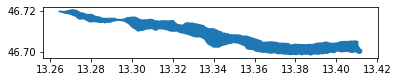

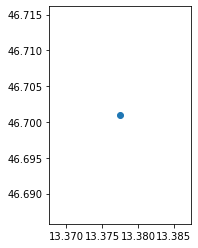

In [158]:
polygon.plot()
dll[(dll['7_scene_id']==scid)|(dll['8_scene_id']==scid)].plot()

In [160]:
m = Map(center=(52.3,8.0), zoom = 3, basemap= basemaps.Esri.WorldTopoMap)

lakes_plot = GeoData(geo_dataframe = polygon,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Large Lakes')

# #lakes_point = GeoData(geo_dataframe = dll[(dll['7_scene_id']==scid)|(dll['8_scene_id']==scid)],
#                    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
#                    name = 'Large Lakes')


m.add_layer(lakes_plot)
m.add_control(LayersControl())

m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [136]:
### Append geometries from shapefile

scid = 'LE71910272009237ASN00'

In [150]:
dll.loc[(dll['7_scene_id']==scid)|(dll['8_scene_id']==scid),]

,,parameterWaterBodyCategory,observedPropertyDeterminandCode,resultObservedValue,geometry,checked,7_scene_tf,8_scene_tf,7_scene_id,7_scene_dt,8_scene_id,8_scene_dt,downloaded,displayId
sid,dt,,,,,,,,,,,,,
ATSE20501000,2009-08-24,LW,EEA_3164-01-0,1.0,POINT (13.37748 46.70096),1,2.0,0.0,LE71910272009237ASN00,2009-08-25T09:38:52,NaN,NaN,False,LE07_L1TP_191027_20090825_20161220_01_T1


### Open scene metadata

In [143]:
sc_meta = pickle.load(open('./Landsat/Scenes/scene_'+str(scid)+".p","rb"))

dll.loc[(dll['7_scene_id']==scid)|(dll['8_scene_id']==scid),'displayId'] = sc_meta[0]['displayId']

### Download raster images

https://pypi.org/project/landsatxplore/

In [2]:
user = 'clement.attwood.18@ucl.ac.uk'
password = 'm9.iETxKMtZ6B,q'

api = landsatxplore.api.API(user,password)

ee = EarthExplorer(user, password)

In [36]:
ddir = 'C:\\Users\\User\\Documents\\Work\\SDGs and AI\\6.3.2\\Landsat'

ee.download(scene_id='LE71910272009237ASN00', output_dir=ddir)

ee.logout()

258MB [02:12, 2.04MB/s]                                                        


#### Alternative options for access

http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF

#### Construct url path from display id from scene metadata

In [237]:
groot = 'https://storage.googleapis.com/gcp-public-data-landsat/'
displayid = sc_meta[0]['displayId']
platform = displayid[0:4]
key = displayid[10:13]+'/'+displayid[13:16]

### choose bands to download
band = 'B1'

filepath = groot+platform+'/01/'+key+'/'+displayid+'/'+displayid+'_'+band+'.TIF'

https://storage.googleapis.com/gcp-public-data-landsat/LE07/01/191/027/LE07_L1TP_191027_20090825_20161220_01_T1/LE07_L1TP_191027_20090825_20161220_01_T1_B1.TIF


### Open source

In [ ]:
with rasterio.open(filepath) as src:
    print(src.profile)

### Open .tar file and import band files

In [125]:
### create dictionary containing raster images for each band

tifs = dict()

tar = tarfile.open("./Landsat/LE07_L1TP_191027_20090825_20161220_01_T1.tar.gz")
for member in tar.getmembers():
    f = tar.extractfile(member)
    
    if (member.name.endswith('.TIF')==True):
        name = member.name.split("T1_")[1].replace(".TIF","")
        with rio.open(f) as src:
            tifs[name] = src.read(1)

### Clip and mask raster to polygon

In [203]:
def cropper(raster, geoms, outpath):
    """
    This function accepts a raster object, an interable list of geometrys (or a single geometry),
    and a filepath to save the cropped raster to, the cropped raster is then read back in and returned.
    """    
    ## As crop accepts an iterable of geoms we first put any single geoms into a list
    if not isinstance(geoms, Iterable):
        geoms = [geoms]

    ## Next we crop the image
    raster_crop, raster_crop_meta = es.crop_image(raster, geoms)

    ## We now need to update the metadata with the spatial data
    raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                             'height': raster_crop.shape[1],
                             'width': raster_crop.shape[2],
                             'nodata': raster_crop.min()}) # <- This is the 'mask' value
    
    with rio.open(outpath, 'w', **raster_crop_meta) as file:
        file.write(raster_crop[0], 1)
        
    raster_crop = rio.open(outpath)
    
    return raster_crop

In [225]:
ras

In [223]:
ras = rio.open(f)

In [222]:
ras.indexes, ras.dtypes

AttributeError: '_GeneratorContextManager' object has no attribute 'indexes'

In [218]:
outpath = './Landsat/Cropped/'+str(scid)+'_'+str('B1')
raster = ras
geoms = polygon

## Next we crop the image
raster_crop, raster_crop_meta = es.crop_image(raster, geoms)

## We now need to update the metadata with the spatial data
raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                         'height': raster_crop.shape[1],
                         'width': raster_crop.shape[2],
                         'nodata': raster_crop.min()}) # <- This is the 'mask' value

with rio.open(outpath, 'w', **raster_crop_meta) as file:
    file.write(raster_crop[0], 1)

raster_crop = rio.open(outpath)

AttributeError: '_GeneratorContextManager' object has no attribute 'nodata'

In [210]:
type(tifs['B1'])

numpy.ndarray

In [208]:
raster_crop, raster_crop_meta = es.crop_image(raster, geoms)

AttributeError: 'numpy.ndarray' object has no attribute 'nodata'

In [207]:
list(raster_crop_meta)

NameError: name 'raster_crop_meta' is not defined

In [205]:
B1_cropped = cropper(tifs['B1'], polygon, './Landsat/Cropped/'+str(scid)+'_'+str('B1'))

AttributeError: 'numpy.ndarray' object has no attribute 'nodata'

### Add data metadata to sites list

In [ ]:
dll[(dll['7_scene_id']==scid)|(dll['8_scene_id']==scid)].head()

### Delete original tar file

In [ ]:
os.remove()

### Plot raster

https://geohackweek.github.io/raster/04-workingwithrasters/

In [189]:
## crs = rasterio.crs.CRS.from_epsg(4258)

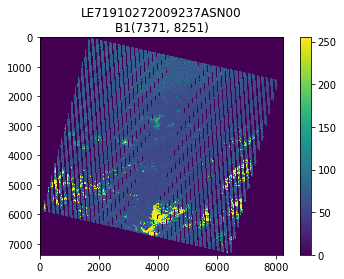

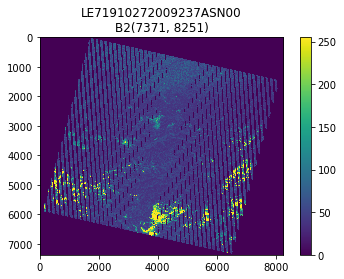

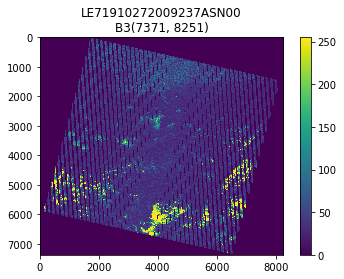

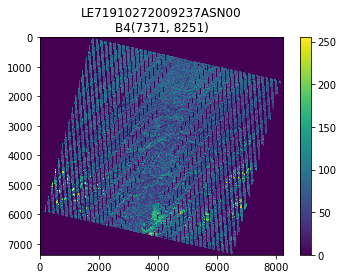

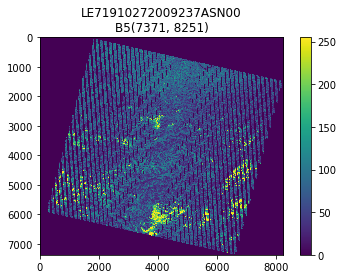

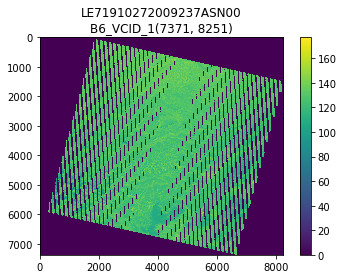

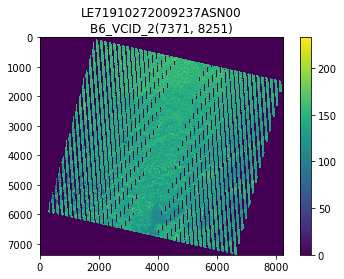

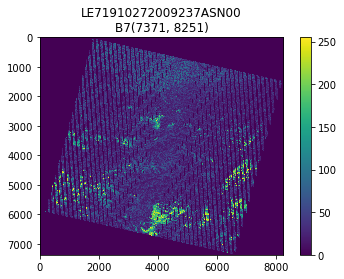

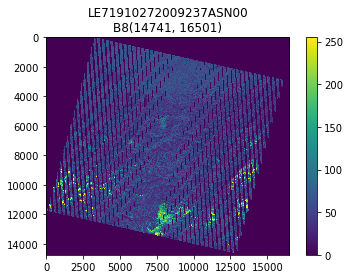

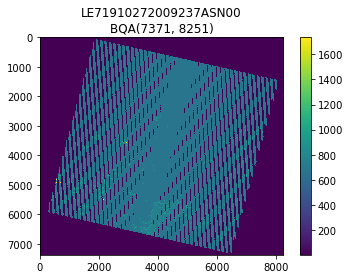

In [171]:
## numpy.dstack()

for k,v in tifs.items():
    
    fig.title(str(scid))
    
    plt.imshow(v)
    plt.colorbar()
    plt.title(str(scid)+'\n'+str(k)+ '{}'.format(v.shape))
    
    plt.show()
#     plt.xlabel('Column #')
#     plt.ylabel('Row #')

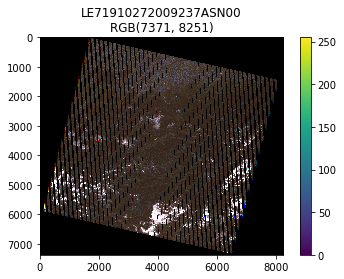

In [188]:

#import matplotlib.image as mpimg

rgb = np.dstack((tifs['B1'],tifs['B2'],tifs['B3']))
    
plt.title(str(scid))

plt.imshow(rgb)
plt.colorbar()
plt.title(str(scid)+'\n'+'RGB'+ '{}'.format(v.shape))

plt.show()